In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# load sdss spectroscopic data

file = '../../../data/spec_data/sdss_dr18_specobj.csv'

sdss = pd.read_csv( file, comment = '#', header = 0 )

# select objects with redshift > 0 and error < 0.1%
sdss = sdss.query( '(redshift >= 0) & (redshift_err < 0.001)' )

# magnitude error < 10%
sdss = sdss.query( ' & '.join([ f'(psf_{filt}_err < 0.1)' for filt in 'ugriz']) )

# drop error estimates
sdss = sdss.drop(columns = ['redshift_err'] + [ f'psf_{filt}_err' for filt in 'ugriz'])

# apply reddening to magnitudes and drop reddening values
for filt in 'ugriz':
    sdss[f'psf_{filt}'] = sdss[f'psf_{filt}'] - sdss[f'ext_{filt}']
sdss = sdss.drop(columns = [ f'ext_{filt}' for filt in 'ugriz'])

# calculate colours {g-i, i-r, r-z} and drop magnitudes except i
last_filt = 'g'
for filt in 'riz':
    sdss[f'{last_filt}-{filt}'] = sdss[f'psf_{last_filt}'] - sdss[f'psf_{filt}']
    last_filt = filt
sdss = sdss.drop(columns = [ f'psf_{filt}' for filt in 'ugrz'])

sdss = sdss.rename(columns = {'psf_i': 'i', 'specObjID': 'obj_id', 'photoRa': 'ra', 'photoDec': 'dec'})

sdss.head(5)

,obj_id,ra,dec,redshift,class,i,g-r,r-i,i-z
0,299574339840272384,145.340589,0.019173,0.120293,GALAXY,17.833546,0.934045,0.481817,0.348238
4,299575439351900160,145.199319,-0.286251,0.651584,QSO,18.989628,-0.039132,0.122512,0.023958
5,299575714229807104,145.281119,-0.330470,0.000111,STAR,19.127551,-0.160424,-0.204357,-0.151502
9,299577088619341824,145.167369,-0.482348,0.062374,GALAXY,19.182535,0.453660,0.246265,0.083281
11,299577638375155712,145.213878,1.151698,1.961112,QSO,18.770396,0.033156,0.144298,0.175907


In [23]:
# classification using magnitude and colours
df = sdss.drop(columns = ['obj_id', 'ra', 'dec', 'redshift'])

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
i,234150.0,15.290004,166.878678,-9999.234833,17.554425,18.083787,18.716605,21.184374
g-r,234150.0,-0.188132,87.838298,-10019.383331,0.323297,0.646995,0.841428,3.414607
r-i,234150.0,0.472689,41.402728,-6.475080,0.218311,0.337587,0.405050,10018.739173
i-z,234150.0,0.465279,54.770549,-10016.356400,0.147972,0.285085,0.368257,10018.332466


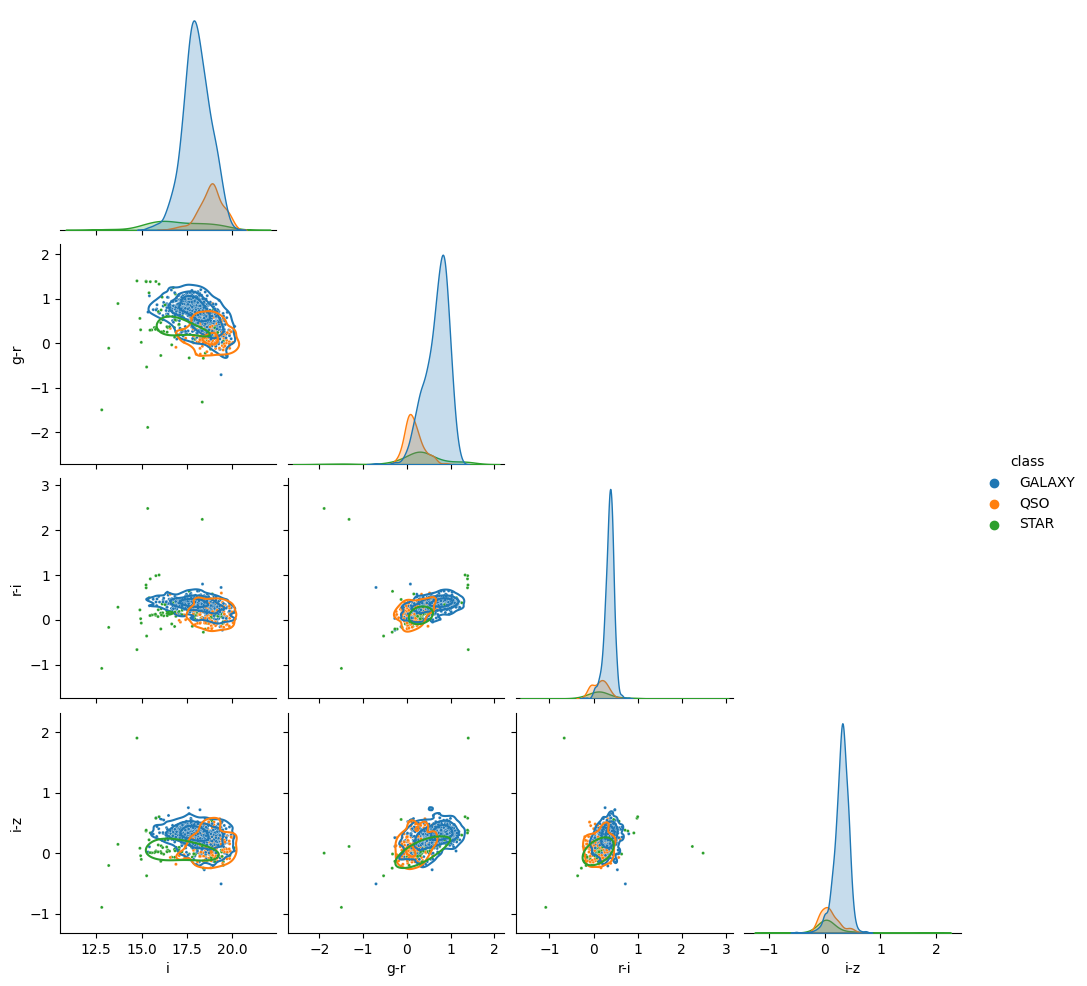

In [5]:

g = sbn.pairplot(df.sample(n = 1000, random_state = 0), 
                 hue = 'class', 
                 corner = True, 
                 diag_kind = 'kde', 
                 plot_kws = {'s': 5},
                 )
g.map_lower(sbn.kdeplot, levels = 4, color = '.2')

## Classification using neural network

In [6]:
import tensorflow as tf

2023-05-15 12:22:12.089652: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 12:22:12.091518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 12:22:12.123020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 12:22:12.123947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 12:22:12.778909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [7]:
# input feature: colour and i-magnitude
x = df.drop(columns = ['class'])

# output label: class 
y = pd.get_dummies(df['class'], dtype = 'int')

In [8]:
# split to test and train sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.1, random_state = 0)

In [9]:
# create model

# normalising input features
norm_layer = tf.keras.layers.Normalization(axis = 1)
norm_layer.adapt( x_train )

# sequential model
model = tf.keras.Sequential([norm_layer,
                             tf.keras.layers.Dense(128, activation = 'relu'),
                             tf.keras.layers.Dense(3, activation = 'softmax'),
                            ])

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy'],
            )

2023-05-15 12:22:25.631959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
# training

checkpt_path = './tmp/checkpoint'
model_checkpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpt_path,
                                                            save_weights_only = True,
                                                            save_best_only = True,
                                                            monitor = 'val_accuracy',
                                                            mode = 'max',
                                                            )

history = model.fit(x_train, 
                    y_train,
                    validation_split = 0.2,
                    epochs = 50,
                    verbose = 1,
                    callbacks = [model_checkpt_callback, ],
                    use_multiprocessing = True,
                    workers = 32,
                )

_ = model.load_weights(checkpt_path) # load saved best model

Epoch 1/50
5269/5269 [==============================] - 16s 3ms/step - loss: 0.5961 - accuracy: 0.7895 - val_loss: 0.4959 - val_accuracy: 0.8162
Epoch 2/50
5269/5269 [==============================] - 15s 3ms/step - loss: 0.4871 - accuracy: 0.8377 - val_loss: 0.4438 - val_accuracy: 0.8401
Epoch 3/50
5269/5269 [==============================] - 10s 2ms/step - loss: 0.4362 - accuracy: 0.8538 - val_loss: 0.3929 - val_accuracy: 0.8642
Epoch 4/50
5269/5269 [==============================] - 15s 3ms/step - loss: 0.3944 - accuracy: 0.8723 - val_loss: 0.3773 - val_accuracy: 0.8715
Epoch 5/50
5269/5269 [==============================] - 15s 3ms/step - loss: 0.3754 - accuracy: 0.8754 - val_loss: 0.3760 - val_accuracy: 0.8728
Epoch 6/50
5269/5269 [==============================] - 13s 2ms/step - loss: 0.3640 - accuracy: 0.8768 - val_loss: 0.3662 - val_accuracy: 0.8753
Epoch 7/50
5269/5269 [==============================] - 12s 2ms/step - loss: 0.3531 - accuracy: 0.8775 - val_loss: 0.3669 - val_ac

Text(0, 0.5, 'Accuracy')

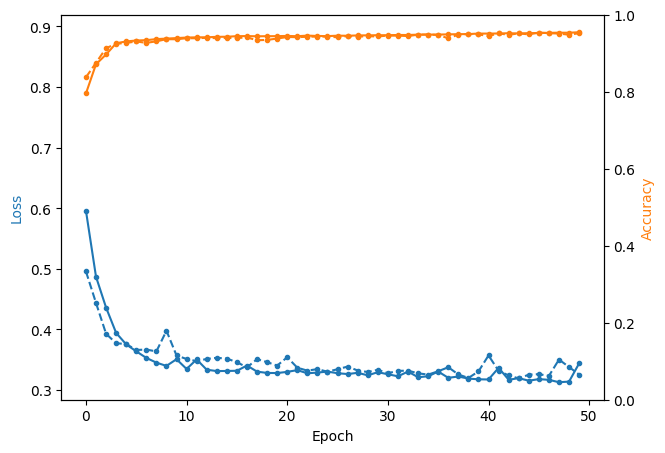

In [12]:
fig, ax1 = plt.subplots(figsize = [7, 5])
ax2 = ax1.twinx()

ax1.plot(history.history['loss'], 'o-', ms = 3, color = 'C0')
ax1.plot(history.history['val_loss'], 'o--', ms = 3, color = 'C0')

ax1.plot(history.history['accuracy'], 'o-', ms = 3, color = 'C1')
ax1.plot(history.history['val_accuracy'], 'o--', ms = 3, color = 'C1')

ax1.set_xlabel('Epoch') 
ax1.set_ylabel('Loss', color = 'C0')
ax2.set_ylabel('Accuracy', color = 'C1')

In [13]:
# test accuracy
score = model.evaluate(x_test, y_test, verbose = 1)

print(f'test accuracy: {score[1]:.3f}')

732/732 [==============================] - 1s 2ms/step - loss: 0.3239 - accuracy: 0.8853
test accuracy: 0.885


In [14]:
# prediction
y_pred = model.predict(x_test)

y_pred

732/732 [==============================] - 1s 1ms/step


array([[9.9297208e-01, 5.3691538e-03, 1.6587107e-03],
       [9.8781699e-01, 1.1501148e-02, 6.8179349e-04],
       [9.8880881e-01, 3.5842329e-03, 7.6069604e-03],
       ...,
       [9.9022126e-01, 7.7073108e-03, 2.0714854e-03],
       [9.8955929e-01, 2.9286670e-03, 7.5119687e-03],
       [6.5839690e-01, 3.1843838e-01, 2.3164708e-02]], dtype=float32)

7318/7318 [==============================] - 9s 1ms/step


/home/darkmatter/Documents/ms3/python/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/darkmatter/Documents/ms3/python/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


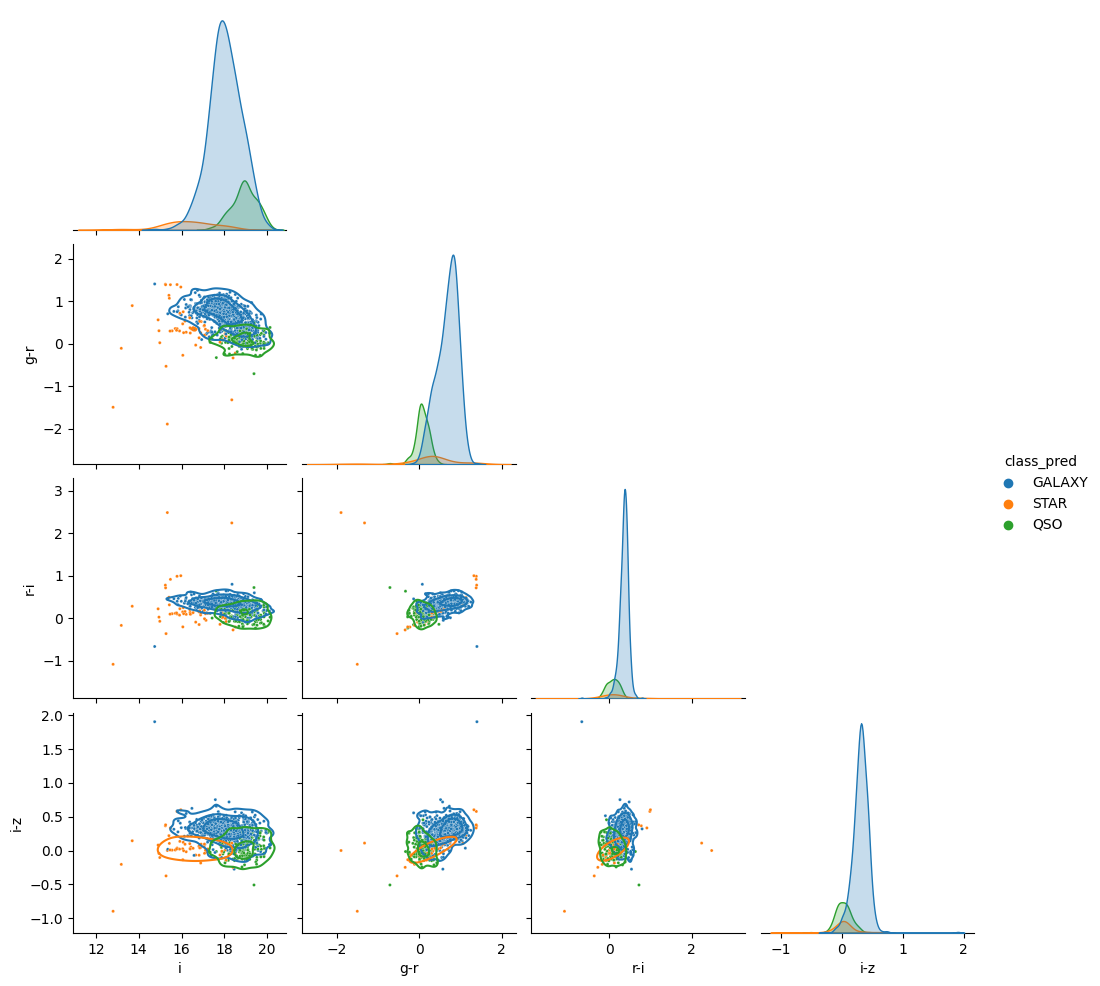

In [29]:
df2 = df.drop(columns = ['class'])

y_pred = model.predict( df2.to_numpy() )
df2['class_pred'] = y_pred.argmax(1)
df2['class_pred'] = df2['class_pred'].map( dict( zip( range(3), y.columns ) ) )

g = sbn.pairplot(df2.sample(n = 1000, random_state = 0), 
                 hue = 'class_pred', 
                 corner = True, 
                 diag_kind = 'kde', 
                 plot_kws = {'s': 5},
                 )
g.map_lower(sbn.kdeplot, levels = 4, color = '.2')

In [21]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(3, random_state = 0, verbose = 2)
# gmm.fit(x_train)

Initialization 0


: 

: 